In [1]:
# Import the packages
import psi4
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from helper_CC_ML_old import *
import matplotlib.pyplot as plt
import os
MLt2=0

In [2]:
# Below is a list of features utilized in the DDCCSD scheme
features = ['Evir1', 'Hvir1', 'Jvir1', 'Kvir1', 
            'Evir2', 'Hvir2', 'Jvir2', 'Kvir2', 
            'Eocc1', 'Jocc1', 'Kocc1', 'Hocc1',
            'Eocc2', 'Jocc2', 'Kocc2', 'Hocc2', 
            'Jia1', 'Jia2', 'Kia1', 'Kia2', 
            'diag', 'orbdiff', 'doublecheck', 
            't2start', 't2mag', 't2sign', 
            'Jia1mag', 'Jia2mag', 'Kia1mag', 'Kia2mag']
'''
Key:
Letters:
E-Energy of the orbital
H-1e contribution to the orbital energy
J-Coulombic contribution to orbital energy
K-Exchange contribution to orbital energy
Placement: occ or virt
Number: is it electron one or two from the two electron excitation


Jia1- coulomb integral between orbital occ1 and vir1
Jia2 " but 2
Kia1 - exchange integral between orbital 
Kia2 Same but exchange integral
diag - is it on the diagonal, aka, are the two excited electrons going to the same orbital **this is important fyi
orbdiff - (Evir2 + Evir1 - Eocc1 - Eocc2)
doublecheck - full 2electron integral
t2start - INITIAL MP2 amplitude **this is the inital guess
t2mag - np.log10(np.absolute(t2start)) ~ this is going to be a common trend, since it is more straightforward for ML algorithms to understand
t2sign - (t2start > 1)? 
Jia1mag - np.log10(np.absolute(feature))
Jia2mag np.log10(np.absolute(feature))
Kia1mag  np.log10(np.absolute(feature))
Kia2mag np.log10(np.absolute(feature))

'''

# These feature weights have been optimized through a gridsearch optimization
factors=(1,1.25,1.5,2,5,10,100,1000)

factor= np.zeros((len(features)))
finalfactor=factor
factor[2]=3
factor[6]=3
factor[12]=4
factor[8]=4
factor[16]=1
factor[17]=1
factor[20]=5
factor[21]=5
factor[22]=6
factor[23]=6
factor[24]=5
factor[25]=1
factor=factor.astype(int)

for j in range(0,len(features)):
    a=factor[j]
    finalfactor[j]=factors[a]


In [3]:
# This function extracts the features and the t2 amplitudes for the training set.

def GetAmps(Foldername, occ=False, vir=False):
    i=1
    for filename in os.listdir(str(Foldername)):
            psi4.core.clean()
            file_path=str(str(Foldername)+filename)
            text = open(file_path, 'r').read()
            mol = psi4.geometry(text)
            psi4.core.clean()


            psi4.set_options({'basis':        'cc-pVDZ',#'6-31g',
                              'scf_type':     'pk',
                              'reference':    'rhf',
                              'mp2_type':     'conv',
                              'e_convergence': 1e-8,

                              'd_convergence': 1e-8})

            A=HelperCCEnergy(mol)

            A.compute_energy()
            matrixsize=A.nocc*A.nocc*A.nvirt*A.nvirt
            Bigmatrix=np.zeros([matrixsize, len(features)])
            for x in range(0,len(features)):
                Bigmatrix[:, x]=getattr(A, features[x]).reshape(matrixsize)
            Bigamp=A.t2.reshape(matrixsize,1)
            if i==1:
                Bigfeatures=Bigmatrix
                Bigamps=Bigamp
                i=2
            else:
                Bigfeatures=np.vstack((Bigfeatures,Bigmatrix))
                Bigamps=np.vstack((Bigamps,Bigamp))

    array=Bigfeatures
    finalamps=Bigamps
    
    return array,finalamps


# Error Calculation

- Error is calculated using following equation:

$$Error = |Final Energy - Start Energy|$$

- Start Energy = Energy calculated by substituting the predicted $t_{2}$ amplitude to CCSD energy equation  
- Final Energy = Energy calculated by substituting the optimized $t_{2}$ amplitude to CCSD energy equation

In [4]:
# This function retrives the features for the test set and then predicts the t2 amplitudes.
# The predicted amplitudes are then passed back to Psi4 for the CCSD energy to be iteratively optimized.

def Test(Foldername, occ=False, vir=False):
    steps=list()
    difference=list()
    supalist=list()
    startenergy=list()
    finalenergy=list()
    filenames=list()
    rhfenergy=list()
    OH_distance_list = list()
    for filename in os.listdir(Foldername):
                psi4.core.clean()
                filenames.append(filename)
                print ("filename is "+filename)
                file_path=str(Foldername+filename)
                xyz_file = open(file_path, 'r')
                text = xyz_file.read()
                xyz_file.close()
                
                xyz_file = open(file_path, 'r')
                text_lines = xyz_file.readlines()
                xyz_file.close()
                
                print(file_path)
                
                mol = psi4.geometry(text)

                psi4.set_options({'basis':        'cc-pVDZ',
                                  'scf_type':     'pk',
                                  'maxiter':      1000,
                                  'reference':    'rhf',
                                  'mp2_type':     'conv',
                                  'e_convergence': 1e-8,
                                  'd_convergence': 1e-8})
                
                MLt2=0
                A=HelperCCEnergy(mol)
                
                matrixsize=A.nocc*A.nocc*A.nvirt*A.nvirt
                Xnew=np.zeros([1,matrixsize,len(features)])
                for x in range (0,len(features)):
                    Xnew[0,:,x]=getattr(A, features[x]).reshape(matrixsize)

                Xnew=np.reshape(Xnew, (matrixsize,len(features)))


                X_new_scaled= scaler.transform(Xnew)
                X_newer_scaled= X_new_scaled
                
                for x in range (0,len(features)):
                    X_newer_scaled[:,x] *= finalfactor[x]



                ynew2=knn.predict(X_newer_scaled)
                MLt2=ynew2.reshape(A.nocc,A.nocc,A.nvirt,A.nvirt)
                A.t2=MLt2
                
                OH_distance = float(text_lines[1].split()[2])
                
                A.compute_t1()
                A.compute_energy()
                rhfenergy.append(A.rhf_e)
                startenergy.append(A.StartEnergy)
                finalenergy.append(A.FinalEnergy)
                OH_distance_list.append(OH_distance)
                
    
    startEn = np.add(np.array(startenergy),np.array(rhfenergy))
    finalEn = np.add(np.array(finalenergy),np.array(rhfenergy))
    difference.append(sum( np.abs(np.asarray(startenergy) - np.asarray(finalenergy))) /len(startenergy))
    differences = np.abs(np.asarray(startenergy) - np.asarray(finalenergy))
    
    print('-------------------------------------------------------------------------------------------------------')
    print ('Average Error: ')
    print (difference)
    
    return(startEn, finalEn, OH_distance_list)

In [5]:
# Extract training features (X_train) and amplitudes (y_train)

X_train,y_train=GetAmps('Water/Regular/Water5/')

Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:14:07 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center   

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.6472818251E-02.
  Reciprocal condition number of the overlap matrix is 6.6664559791E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.8245127842E-03.
  Reciprocal condition number of the overlap matrix is 8.1454376710E-04.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.1814038197E-01.
  Reciprocal condition number of the overlap matrix is 4.7492563267E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.5332548779E-01.
  Reciprocal condition number of the overlap matrix is 7.3368309170E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

In [6]:
# Scale the features using a MinMaxScaler in Scikit-Learn

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# Multiply the features by the optimized weights
for a in range(0,len(features)):
    X_train_scaled[:,a] *= finalfactor[a]

# Train the regression model
knn=(KNeighborsRegressor(n_neighbors=1, p=2).fit(X_train_scaled,y_train)  )


In [7]:
# Calls the Test function described above, which returns the start energy, the final, or optimized, energy, and the OH radius

startEnergy, finalEnergy, OH_distance = Test('Water/Water100/')

filename is Water33.xyz
Water/Water100/Water33.xyz
Computing RHF reference.

Scratch directory: /tmp/

*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:14:11 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstro

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.4131936647E-02.
  Reciprocal condition number of the overlap matrix is 9.1974684720E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.7681754290E-02.
  Reciprocal condition number of the overlap matrix is 7.0504458938E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         O            0.000000000000     0.000000000000    -0.057498257587    15.994914619570
         H            0.000000000000    -0.663540300875     0.456269536608     1.007825032230
         H            0.000000000000     0.663540300875     0.456269536608     1.007825032230

  Running in 

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     28.44766  B =     15.14608  C =      9.88377 [cm^-1]
  Rotational constants: A = 852839.45608  B = 454068.13342  C = 296308.03512 [MHz]
  Nuclear repulsion =    9.365273977774828

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Num

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:14:54 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     29.49060  B =     15.70137  C =     10.24613 [cm^-1]
  Rotational constants: A = 884106.08669  B = 470715.08907  C = 307171.22140 [MHz]
  Nuclear repulsion =    9.535402614271947

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Num

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     25.63047  B =     13.64616  C =      8.90498 [cm^-1]
  Rotational constants: A = 768382.19285  B = 409101.46168  C = 266964.45171 [MHz]
  Nuclear repulsion =    8.889462261703429

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Num

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

*** at Fri Jan 28 14:16:02 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   ------------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:16:11 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.3804547603E-01.
  Reciprocal condition number of the overlap matrix is 6.0778942899E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.2180222140E-02.
  Reciprocal condition number of the overlap matrix is 1.9800486164E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.2295743180E-02.
  Reciprocal condition number of the overlap matrix is 1.5851366243E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.4463892601E-01.
  Reciprocal condition number of the overlap matrix is 6.5901086446E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.0683164257E-03.
  Reciprocal condition number of the overlap matrix is 1.0886152112E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.8245127842E-03.
  Reciprocal condition number of the overlap matrix is 8.1454376710E-04.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.3357372269E-01.
  Reciprocal condition number of the overlap matrix is 5.7538207989E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.4212336819E-01.
  Reciprocal condition number of the overlap matrix is 6.3894933282E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.6103457613E-02.
  Reciprocal condition number of the overlap matrix is 1.7344994154E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.6441824197E-02.
  Reciprocal condition number of the overlap matrix is 2.1576541869E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.4173634599E-02.
  Reciprocal condition number of the overlap matrix is 1.6583715930E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.3510970580E-01.
  Reciprocal condition number of the overlap matrix is 5.8631873902E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:20:14 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.4813572008E-01.
  Reciprocal condition number of the overlap matrix is 6.8803972001E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.6991423073E-02.
  Reciprocal condition number of the overlap matrix is 1.3827312483E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.7631481256E-02.
  Reciprocal condition number of the overlap matrix is 2.6462770483E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.8703225427E-02.
  Reciprocal condition number of the overlap matrix is 1.4473349130E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


Scratch directory: /tmp/

*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:21:26 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X             

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


Scratch directory: /tmp/

*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:21:34 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X             

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 8.3732795358E-03.
  Reciprocal condition number of the overlap matrix is 1.8343247943E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.4923352293E-01.
  Reciprocal condition number of the overlap matrix is 6.9743717989E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.3036216757E-01.
  Reciprocal condition number of the overlap matrix is 5.5312739571E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:22:10 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:22:59 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.4609413619E-03.
  Reciprocal condition number of the overlap matrix is 1.6258320721E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.0942550184E-01.
  Reciprocal condition number of the overlap matrix is 4.2425728478E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 8.2241287454E-02.
  Reciprocal condition number of the overlap matrix is 2.8575033832E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 9.3279041207E-03.
  Reciprocal condition number of the overlap matrix is 2.0547937064E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.5234447712E-01.
  Reciprocal condition number of the overlap matrix is 7.2481882762E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 9.8393946619E-02.
  Reciprocal condition number of the overlap matrix is 3.6488859032E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:24:45 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


Scratch directory: /tmp/

*** tstart() called on Griers-Research-MacBook-Air.local
*** at Fri Jan 28 14:25:21 2022

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X             

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.3944709697E-01.
  Reciprocal condition number of the overlap matrix is 6.1831743501E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.4080598675E-01.
  Reciprocal condition number of the overlap matrix is 6.2870446680E-02.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


Initalizing CCSD object...

Starting AO ->  MO transformation...
Size of the ERI tensor is 0.00 GB, 24 basis functions.
Building initial guess...

..initialized CCSD in 0.279 seconds.

         H            0.000000000000    -0.955216899190     0.656834816783     1.007825032230
         H            0.000000000000     0.955216899190     0.656834816783     1.007825032230

  Running in c1 symmetry.

  Rotational constants: A =     17.21566  B =      9.16595  C =      5.98136 [cm^-1]
  Rotational constants: A = 516112.44182  B = 274788.19304  C = 179316.59053 [MHz]
  Nuclear repulsion =    7.285494071004768

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend:

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     12.65066  B =      6.73545  C =      4.39531 [cm^-1]
  Rotational constants: A = 379257.12872  B = 201923.79152  C = 131767.98261 [MHz]
  Nuclear repulsion =    6.245305984032182

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Num

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

   => Loading Basis Set <=

    Name: CC-PVDZ
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   198 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 
    atoms 2-3 entry H          line    22 file /Users/gjonesresearch/miniconda3/envs/p4env/share/psi4/basis/cc-pvdz.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -------

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         O            0.000000000000     0.000000000000    -0.041414248122    15.994914619570
         H            0.000000000000    -0.477927920130     0.328637085588     1.007825032230
         H            0.000000000000     0.477927920130     0.328637085588     1.007825032230

  Running in 

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     65.10821  B =     34.66486  C =     22.62101 [cm^-1]
  Rotational constants: A = 1951895.02167  B = 1039226.46028  C = 678160.67199 [MHz]
  Nuclear repulsion =   14.168212860035288

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      N

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     72.75093  B =     38.73399  C =     25.27637 [cm^-1]
  Rotational constants: A = 2181018.02153  B = 1161215.95329  C = 757766.49394 [MHz]
  Nuclear repulsion =   14.976711771952049

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      N

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     22.48146  B =     11.96956  C =      7.81089 [cm^-1]
  Rotational constants: A = 673977.23433  B = 358838.44559  C = 234164.67026 [MHz]
  Nuclear repulsion =    8.325483383261707

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Num

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     23.21195  B =     12.35849  C =      8.06469 [cm^-1]
  Rotational constants: A = 695876.60908  B = 370498.09401  C = 241773.32469 [MHz]
  Nuclear repulsion =    8.459661076623009

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Num

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.1322413809E-02.
  Reciprocal condition number of the overlap matrix is 2.5237363524E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.8674747623E-02.
  Reciprocal condition number of the overlap matrix is 7.3707992896E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     61.73078  B =     32.86665  C =     21.44756 [cm^-1]
  Rotational constants: A = 1850642.13250  B = 985317.47417  C = 642981.66564 [MHz]
  Nuclear repulsion =   13.795837411212320

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Nu

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     58.60949  B =     31.20482  C =     20.36311 [cm^-1]
  Rotational constants: A = 1757068.26369  B = 935496.94623  C = 610470.63556 [MHz]
  Nuclear repulsion =   13.442534570999229

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Nu

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

c1 symmetry.

  Rotational constants: A =     31.75621  B =     16.90762  C =     11.03328 [cm^-1]
  Rotational constants: A = 952027.13222  B = 506877.56038  C = 330769.50992 [MHz]
  Nuclear repulsion =    9.894902235886562

  Charge       = 0
  Multiplicity = 1
  Electrons    = 10
  Nalpha       = 5
  Nbeta        = 5

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-09
  Density threshold  = 1.00e-09
  Integral threshold = 1.00e-12

  ==> Primary Basis <==

  Basis Set: CC-PVDZ
    Blend: CC-PVDZ
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Num

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.8328039353E-02.
  Reciprocal condition number of the overlap matrix is 4.2882830502E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:206: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'SCF_TYPE': 'PK'})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:207: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'E_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:208: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and in 1.5 it will stop working

  psi4.set_module_options('SCF', {'D_CONVERGENCE': 10e-10})
/Users/gjonesresearch/DDQC_Demo/DDCCSD/helper_CC_ML_old.py:209: FutureWarning: Using `psi4.set_module_op

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   3
      Number of AO shells:              12
      Number of primitives:             32
      Number of atomic orbitals:        25
      Number of basis functions:        24

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 90300 doubles for integral storage.
  We computed 3081 shell quartets total.
  Whereas there are 3081 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 1.7364270223E-02.
  Reciprocal condition number of the overlap matrix is 4.0321383017E-03.
    Using symmetric orthogonalization.

  ==> Pre-Iteration

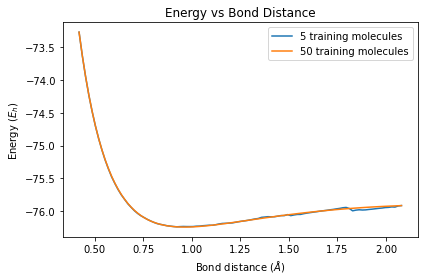

In [8]:
# Plot the start energy and final energy against bond distance

zipped_lists = zip(OH_distance, startEnergy, finalEnergy)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
BondDistance, StartEnergy, FinalEnergy = [ list(tuple) for tuple in  tuples]

plt.title('Energy vs Bond Distance')
plt.xlabel('Bond distance ($\AA$)')
plt.ylabel('Energy ($E_{h}$)')
plt.plot(BondDistance, StartEnergy, label = '5 training molecules')
plt.plot(BondDistance, FinalEnergy, label = '50 training molecules')
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig('new_Varuna_figure.png',dpi=300)
plt.show()